# 11-experiment-three-cogsci

## Integrity

In [18]:
# Analytical Tools
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# General Utilities
import itertools
import json
import pprint

# Custom Utilities
import utilities.plotting as plotting
import utilities.describe as describe

# Some settings
log = pprint.pprint
%matplotlib inline
pd.options.mode.chained_assignment = None

### Reading Data

In [19]:
QUESTIONS = 10
JUDGMENTS = 4

FILE_NAMES = [
    'data/baseline_final.json', #raw is initial one that may have duplicates, we take the non-duplicates from it
     'data/raw.json',
]

master_responses = []
for name in FILE_NAMES:
    with open(name) as file:
        master_responses.extend(json.loads(line) for line in file if line)

### Parsing Data

In [20]:
data = {
    'id': [],
    'consent': [],
    'attention': []
}

for q_num in range(QUESTIONS):
    data['q{}_score'.format(q_num)] = []
    data['q{}_index'.format(q_num)] = []
    for j_num in range(JUDGMENTS):
        data['q{}_j{}'.format(q_num, j_num)] = []

In [21]:
ANSWER_KEYS = ('Q0', 'Q1', 'Q2', 'Q3')

for person in master_responses:
    # Grab data & ID
    person_data = person['data']  
    data['id'].append(person_data[0]['participantID'])
    
    # Fill in question labels
    question_scores = person_data[0]['questionScores']
    question_indices = person_data[0]['questionIndices']
    
    for q_num, score in zip(range(QUESTIONS), question_scores):
        data['q{}_score'.format(q_num)].append(score)
    for q_num, score in zip(range(QUESTIONS), question_indices):
        data['q{}_index'.format(q_num)].append(score)  
    
    # Get consent response
    consent_answer = json.loads(person_data[0]['responses'])
    consent_value = int(consent_answer['Q0'].startswith('I consent'))
    data['consent'].append(consent_value)

    # Fill in judgments
    judgment_indices = person_data[0]['judgmentIndices']
    
    for q_num, likert_index in zip(range(QUESTIONS), range(2, 12)):
        answer = json.loads(person_data[likert_index]['responses'])
        for j_label, key in zip(judgment_indices, ANSWER_KEYS):
            rating = int(answer[key])
            data['q{}_j{}'.format(q_num, j_label)].append(rating)

    # Attention check
    attention_answer = json.loads(person_data[7]['responses'])
    attention_value = int(attention_answer['Q4'] == '6')
    data['attention'].append(attention_value)

### Reading Responses into Data

In [22]:
data = pd.DataFrame(data)
sample_size = len(data)
data.head()


,attention,consent,id,q0_index,q0_j0,q0_j1,q0_j2,q0_j3,q0_score,q1_index,...,q8_j1,q8_j2,q8_j3,q8_score,q9_index,q9_j0,q9_j1,q9_j2,q9_j3,q9_score
0,1,1,sfmcx2twvmsm0d9qpnq19vpmrd27oqtr,18,4,0,0,0,None,24,...,2,3,3,None,37,0,6,6,3,None
1,1,1,qrw87p430tabkol0mxj9q3dkm1p4o423,5,5,1,4,2,None,29,...,4,5,1,None,23,4,1,3,1,None
2,0,1,2yfjc32hqne6avf0a6kaxbhftw6ydo47,26,0,1,0,1,None,30,...,3,4,4,None,41,0,0,0,0,None
3,1,1,076dogp6qxwgm1aqfmdryebkh30e4w9m,20,3,0,1,1,None,25,...,0,3,1,None,40,0,0,0,0,None
4,1,1,um8loq05sq31yj9f54c4rhxfhjsx7uac,38,1,0,0,0,None,3,...,4,1,2,None,27,3,3,2,2,None


In [23]:
print(len(data), data.size)
data = data[data.consent == 1]
print(len(data), data.size)
data = data[data.attention == 1]
print(len(data), data.size)

print('Inclusion: {:.4}% '.format(len(data) / sample_size * 100))

298 18774
298 18774
278 17514
Inclusion: 93.29% 


In [24]:
judgments = []
for q_num in range(QUESTIONS):
    for j_num in range(JUDGMENTS):
        judgments.append('q{}_j{}'.format(q_num, j_num))
scores = data[judgments]
data['j_mean'] = scores.mean(axis=1)
data['j_std'] =scores.std(axis=1)



In [36]:
#Based on reviewer's comments, we are commenting this out i.e. we keep all subjects, and only remove people who failed the attention check
print(len(data), data.size)
data = data[data.j_std > 0.75]
index = np.argmin(data['j_std'])
print(scores.loc[[index]].values)
print('Inclusion: {:.4}% '.format(len(data) / sample_size * 100))

278 19182
[[3 2 2 2 3 3 2 2 4 3 3 3 4 2 4 4 4 2 3 3 3 2 3 3 4 2 4 4 3 3 3 3 2 2 2 2 4
  2 3 3]]
Inclusion: 91.61% 


C:\Users\RACH0_000\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:1033: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return argmin(axis, out)


## Analysis

In [25]:
for j_num in range(JUDGMENTS):
    headings = []
    for q_num in range(QUESTIONS):
        headings.append('q{}_j{}'.format(q_num, j_num))

    rating_mean = data[headings].mean(axis=1)
    data['j{}_mean'.format(j_num)] = rating_mean

In [26]:
means, errs = [], []
for j_num in range(JUDGMENTS):
    values = data['j{}_mean'.format(j_num)]
    means.append(values.mean())
    errs.append(stats.sem(values))

print(means)
print(errs)

[3.484172661870501, 1.6143884892086335, 2.6496402877697847, 2.2496402877697848]
[0.070870306286352741, 0.073527979289866943, 0.072476010128252444, 0.071703222764052096]


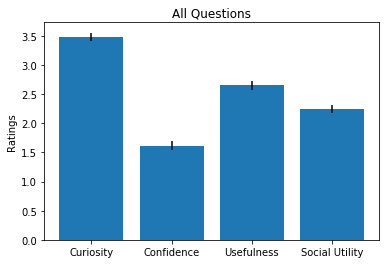

In [27]:
PLOTTING_OPTIONS = {
    'ylabel': 'Ratings',
    'ticks': ['Curiosity', 'Confidence', 'Usefulness', 'Social Utility'],
    'title': 'All Questions'
}
plotting.plot_single_bar(means, errs, **PLOTTING_OPTIONS)

# U-shape analysis

In [28]:
all_confidences = {num: [] for num in range(7)}
for index, row in data.iterrows():
    num = [] #compute mean of questions
    for q_num in range(QUESTIONS):
        num.append(row['q{}_j0'.format(q_num)]) #for each subject compute their mean rating for q's        
    for q_num in range(QUESTIONS):
        cur_rating = row['q{}_j0'.format(q_num)] - np.mean(num)
        conf_rating = row['q{}_j1'.format(q_num)]
        all_confidences[conf_rating].append(cur_rating)        


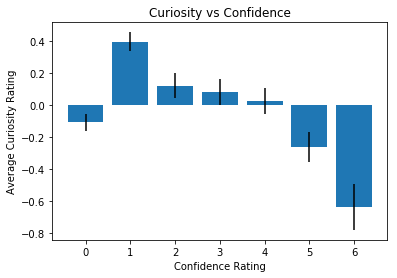

In [29]:
import matplotlib.pyplot as plt

PLOTTING_OPTIONS = {
    'ylabel': 'Average Curiosity Rating',
    'xlabel': 'Confidence Rating',
    'title': 'Curiosity vs Confidence',
}


means = [np.mean(all_confidences[num]) for num in range(7)]
stderr = [stats.sem(all_confidences[num]) for num in range(7)]
    
plotting.plot_single_bar(
    means, stderr,
    **PLOTTING_OPTIONS
)
plt.show()

In [30]:
from sklearn import preprocessing

x_values = []
y_values = []
for num in range(7):
    x_values += [num / 6 for _ in range(len(all_confidences[num]))]
    y_values += all_confidences[num]

x_values = np.reshape(np.array(x_values), (-1, 1))
y_values = np.reshape(np.array(y_values), (-1, 1))
x_values_quadratic = preprocessing.PolynomialFeatures(2).fit_transform(x_values)

print(x_values)
print(x_values_quadratic)

[[ 0.]
 [ 0.]
 [ 0.]
 ..., 
 [ 1.]
 [ 1.]
 [ 1.]]
[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 ..., 
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]


In [32]:
import statsmodels.api as sm
results = sm.OLS(y_values, x_values_quadratic).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     25.98
Date:                Thu, 12 Sep 2019   Prob (F-statistic):           6.61e-12
Time:                        11:43:07   Log-Likelihood:                -5159.9
No. Observations:                2780   AIC:                         1.033e+04
Df Residuals:                    2777   BIC:                         1.034e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0605      0.043     -1.408      0.159      -0.145       0.024
x1             1.7153      0.304      5.634      0.000       1.118       2.312
x2            -2.3572      0.349     -6.747      0.000      -3.042      -1.672
==============================================================================
Omnibus:                       12.853   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.921
Skew:                          -0.167   Prob(JB):                      0.00156
Kurtosis:                       3.023   Cond. No.                         16.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
result = results.params

print('Best Polynomial')
print('y = {:.4}x^2 + {:.4}x + {:.4}'.format(result[2], result[1], result[0]))
print('y = {:.4}x(1 - x) + {:.4}x '.format(-result[2], result[1] + result[2], result[0]))

Best Polynomial
y = -2.357x^2 + 1.715x + -0.06047
y = 2.357x(1 - x) + -0.6419x 


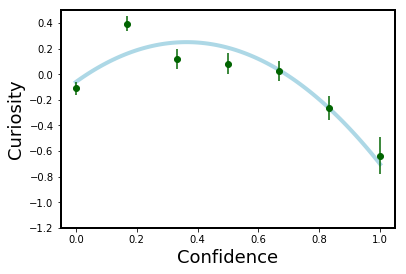

In [34]:
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2 #set the value globally
ax = plt.figure()
poly = np.poly1d(list(reversed(result)))
x_ticks = np.linspace(0, 1, 100)
plt.errorbar(np.linspace(0, 1, 7), means, stderr, color='darkgreen', marker='o', linestyle="None",zorder=2)
plt.plot(x_ticks, poly(x_ticks), '-', linewidth=4.0, color='lightblue', zorder=1)
plt.ylim([-1.2, 0.5])
plt.xlabel('Confidence',fontsize=18)
plt.ylabel('Curiosity',fontsize=18)


ax.savefig('u-shape2b_control.png', bbox_inches='tight', dpi=1200)

In [37]:
data.to_pickle('raw-data/baseline_2b1.pkl')